# Narrative Flow of Men and Women



 ### Hypothesis:

Men and women discuss sociability and solidarity in different ways, i.e. in different contexts. (..) Solidarity and social relations were different in the men and women section of Birkenau; men and women recall them in different ways and contexts. In practice, this means that they are primed and followed by different topics in the narratives of men and women.

If the hypothesis is true:
- the story line (or narrative flow) leading to the discussion of sociability and solidarity is different in testimonies of men and women
- the most likely sequences of topics (to be named narrative pathway) leading to topics describing solidarity and sociability are different
- different amount of traffic is going through  similar pathways leading to solidarity and sociability
- different nodes (to be named priming topics) are preceding and following (to be named exit topics) topics of solidarity and sociability


Key research questions to be studied here:
- What are the major pathways between the memory of arrival to Birkenau and leaving from Birkenau?
- How are nodes related to solidarity (food sharing, aid giving) and social bonds (friends, social bonds, family) are situated along the major pathways? For women and men, are they peripheral or central? I.e. do a significant amount of narrative flow go towards them for men and women?
- What are the exit and priming topics for solidarity (food sharing, aid giving) and social bonds for men and women?
- How are these topics related to survival explanations?
- How is friendship related to aid giving for men and for women? What are the transitory topics between them?
- What are those topics that prime topics of solidarity and social bonds?
- Where did solidarity take place? In what contexts did solidarity take place?
- What topics do topics related to solidarity and social bonds prime for men and women?


In [1]:
import constants
import pandas as pd
import os
from IPython.display import display
import json
import pyemma
from tables import *
import sys; sys.path.insert(0, '..')
from markov_modelling.markov_utils import *

In [2]:
# define the Uwe
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe",
                                                                    [(0, 0, 0, .1), (0, 0, 0, 1)])

## Load the relevant data

Load interview

Set up the paths to data

Two different datasets were created. In Dataset 1, the topic 'social bonds' include 'friendship' as well; similarly the topic 'aid giving' includes 'food sharing'. In Dataset 2, 'friendship' and 'food sharing' are distinguished, and they are different topics.

First, load Dataset 1

In [3]:
input_directory = constants.output_data_markov_modelling
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))
input_directory = parent +'/'+ constants.output_data_markov_modelling
data_set_1_w  = pyemma.load(input_directory+'complete_w'+'/'+'pyemma_model','simple')
data_set_1_m = pyemma.load(input_directory+'complete_m'+'/'+'pyemma_model','simple')
data_set_1_complete = pyemma.load(input_directory+'complete'+'/'+'pyemma_model','simple')
input_directory = parent +'/'+ constants.output_data_segment_keyword_matrix
features_df = pd.read_csv(input_directory+constants.output_segment_keyword_matrix_feature_index)
features_df = features_df.drop(columns=['Unnamed: 0','index'])

/storage/mi/thempel/anaconda3/envs/py37_mar20/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:46: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(name) as h5f:


Load Dataset 2

In [5]:
input_directory = 'data/output_aid_giving_sociability_expanded/markov_modelling/'

path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))
input_directory = parent +'/'+ input_directory
data_set_2_w  = pyemma.load(input_directory+'complete_w'+'/'+'pyemma_model','simple')
data_set_2_m = pyemma.load(input_directory+'complete_m'+'/'+'pyemma_model','simple')
data_set_2_complete = pyemma.load(input_directory+'complete'+'/'+'pyemma_model','simple')
input_directory = parent +'/'+ 'data/output_aid_giving_sociability_expanded/segment_keyword_matrix/'
features_df_2 = pd.read_csv(input_directory+constants.output_segment_keyword_matrix_feature_index)
features_df_2 = features_df_2.drop(columns=['Unnamed: 0','index'])


In [108]:
def get_graphs_msms(msm_stringformat, story_start, story_end, fraction=.95):
    if msm_stringformat.find('1') > 0:
        _features_df = features_df
    else:
        _features_df = features_df_2

    msm = eval(msm_stringformat)
    graph, tpt, pos = get_tpt_major_flux(msm, _features_df, story_start, story_end,
                                         fraction=fraction,)

    return graph, tpt, msm, _features_df

def downsize_nodename_dict(_features_df, msm, subgraph):
    nodename_dict = {i:_features_df.iloc[j].KeywordLabel for i, j in enumerate(msm.active_set)}
    nodename_dict_inv = {v:k for k, v in nodename_dict.items()}
    spathg_nodes = [nodename_dict_inv[k] for k in list(subgraph.nodes)]

    return spathg_nodes


def get_subgraph_around_topic(pathgraph, to_analyze):
    """
    returns sub-graph around a topic with only links into and out of that topic
    """
    neighbors = [to_analyze] + \
                list(pathgraph.successors(to_analyze)) + \
                list(pathgraph.predecessors(to_analyze))
    
    subgraph = nx.DiGraph()
    
    subgraph.add_nodes_from(neighbors)
    allweights = nx.get_edge_attributes(pathgraph, 'weight')
    
    for edges in [pathgraph.in_edges(to_analyze), pathgraph.out_edges(to_analyze)]:
        for edge in edges:
            subgraph.add_edge(*edge, weight=allweights[edge])

    sweights = np.array(list(nx.get_edge_attributes(subgraph, 'weight').values())).astype(float)

    return subgraph, sweights

def plot_small_graph(ax, subgraph, subgraph_weights, probabilities, fruchterman_layout=False):
    if fruchterman_layout:
        subgraph_pos = nx.fruchterman_reingold_layout(subgraph, k=1e-1)
    else:
        subgraph_pos = {to_analyze:np.array([0, 0])}
        
        succ = list(subgraph.successors(to_analyze))
        y_succ = np.linspace(-2, 2, len(succ))
        subgraph_pos.update({n:np.array([1, y_succ[n_]]) for n_, n in enumerate(succ)})
        
        predec = list(subgraph.predecessors(to_analyze))
        y_predec = np.linspace(-2, 2, len(predec))
        subgraph_pos.update({n:np.array([-1, y_predec[n_]]) for n_, n in enumerate(predec)})
                                                  
    nx.draw_networkx_nodes(subgraph, subgraph_pos, 
                           node_size=probabilities*10000, 
                           ax=ax, )
    nx.draw_networkx_labels(subgraph, 
                            {k:v+np.array([0,.2]) for k,v in subgraph_pos.items()}, 
                            ax=ax,
                            labels={n:n for n in list(subgraph.nodes)}, font_size=9)

    nx.draw_networkx_edges(subgraph, subgraph_pos, 
                           node_size=probabilities*10000,
                           edge_cmap=edge_cmap, 
                        edge_color=subgraph_weights, width=2.7, ax=ax);
    ax.axis('off')
    ax.set_xlim(-1.75, 1.75)
    
def print_reactive_pathways_through_node(node, _features_df, msm, tpt, n_paths=3, fraction=0.95):
    nodename_dict = {i:_features_df.iloc[j].KeywordLabel for i, j in enumerate(msm.active_set)}
    paths, capacities = tpt.pathways(fraction)

    n_found = 0
    for n, (path, cap) in enumerate(zip(paths, capacities)):
        pathname_path = [nodename_dict[msm._full2active[i]] for i in path]
        if to_analyze in pathname_path:
            _printpath = [p if p!= node else p.upper() for p in pathname_path]
            print(f'rank: {n}; capacity: {cap}\npath:{_printpath}')
            n_found += 1
        if n_found == n_paths:
            break
            
    if n_found < n_paths:
        print(f'no more paths through {node} in {100*fraction}% of reactive paths')
    return

## Observation 1
### "aid giving"

### Qualitative description

For women, the main topic that primes the discussion of aid giving is the discussion of the living conditions. By contrast, the most important topic that primes aid giving for men is the discussion of forced labour activity. 

For women, the most important narrative trajectory leading to the discussion of aid giving is the following one (8.3 % of the total traffic is going through it):
- arrival-camp intake procedures-living conditions-aid giving

For men, the most important narrative trajectory leading to the discussion of aid giving is the following one (5 % of the total traffic is going through it):
- arrival-selections-camp intake procedures-living conditions-forced labor-aid giving

Both men and women discuss aid giving in the context of camp living conditions and forced labour, women are more likely to discuss it in the context of camp living conditions. While men are more likely to discuss it in the context of forced labour.

data_set_1_m
rank: 11; capacity: 3.296413966752358e-05
path:['arrival', 'selections', 'camp intake procedures', 'tattoo', 'forced labor', 'AID GIVING', 'departure']
rank: 30; capacity: 1.1681986139222092e-05
path:['arrival', 'AID GIVING', 'selections', 'camp intake procedures', 'living conditions', 'mass murder awareness', 'transfer', 'photographs', 'forced labor', 'barter', 'departure']
rank: 37; capacity: 9.183753407679548e-06
path:['arrival', 'Appell', 'transfer', 'AID GIVING', 'selections', 'hiding and evasion', 'departure']

data_set_1_w
rank: 13; capacity: 2.4973795229124555e-05
path:['arrival', 'living conditions', 'forced labor', 'AID GIVING', 'departure']
rank: 22; capacity: 1.570634867421959e-05
path:['arrival', 'tattoo', 'living conditions', 'food and thirst', 'AID GIVING', 'departure']
rank: 38; capacity: 8.668295219314539e-06
path:['arrival', 'AID GIVING', 'selections', 'camp intake procedures', 'living conditions', 'religion', 'departure']



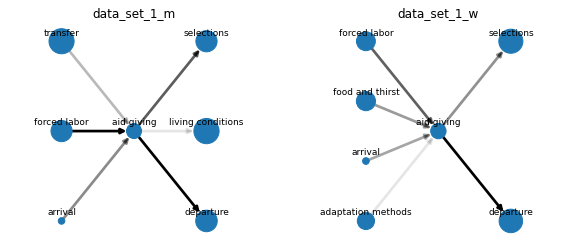

In [109]:
story_start = 'arrival'
story_end = 'departure'
to_analyze = 'aid giving'

msms_str = ['data_set_1_m', 'data_set_1_w']


fig, axes = plt.subplots(1, 2, figsize=(10, 4))


for ax, name in zip(axes, msms_str):
    graph, tpt, msm, _features_df = get_graphs_msms(name, story_start, story_end)
    print(name)
    print_reactive_pathways_through_node(to_analyze, _features_df, msm, tpt)
    
    subgraph, subgraph_weights = get_subgraph_around_topic(graph, to_analyze)

    spathg_nodes = downsize_nodename_dict(_features_df, msm, subgraph)
    
    
    plot_small_graph(ax, subgraph, subgraph_weights, msm.pi[spathg_nodes])
    ax.set_title(name)
    
    print()

## Observation 2
### "food sharing"

### Qualitative description

As above, a key topic that follows the discussion of aid giving is forced labour. However, this has different weight in the narratives of men and women. Men are more likely to discuss forced labour following aid giving. In testimonies of men, more traffic is going through the following pathway (3,6% women versus 6,2% men):

-aid giving-forced labor-departure.

### Qualitative description

Similarly to aid giving, women tend to discuss food sharing in the context of living conditions, whereas men discuss it in the context of forced labour. For women, food sharing is most likely to be primed by the discussion of living conditions, for men food sharing tends to be primed by forced labour. In testimonies of women, the major traffic (16,5%) towards food sharing are going through the following two pathways:
- arrival-camp intake procedures-living conditions-food and thirst-food sharing
- arrival-selections-camp intake procedures-living conditions-food sharing

By contrast, in testimonies of men, the major traffic ( 11.33405389131642%) towards food sharing are going through the following pathways:
- arrival-selections-camp intake procedures-living conditions-forced labor-food sharing




### Visualization

data_set_2_m
rank: 55; capacity: 5.0983069014949174e-06
path:['arrival', "loved ones' contacts", 'tattoo', 'living conditions', 'food and thirst', 'FOOD SHARING', 'departure']
no more paths through food sharing in 95.0% of reactive paths

data_set_2_w
rank: 58; capacity: 5.5626404214093675e-06
path:['arrival', 'living conditions', 'food and thirst', 'FOOD SHARING', 'departure']
no more paths through food sharing in 95.0% of reactive paths



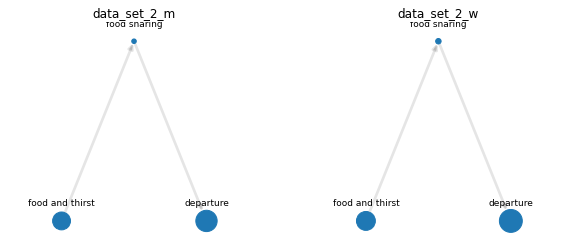

In [110]:
story_start = 'arrival'
story_end = 'departure'
to_analyze = 'food sharing'

msms_str = ['data_set_2_m', 'data_set_2_w']


fig, axes = plt.subplots(1, 2, figsize=(10, 4))


for ax, name in zip(axes, msms_str):
    graph, tpt, msm, _features_df = get_graphs_msms(name, story_start, story_end)
    print(name)
    print_reactive_pathways_through_node(to_analyze, _features_df, msm, tpt)
    
    subgraph, subgraph_weights = get_subgraph_around_topic(graph, to_analyze)

    spathg_nodes = downsize_nodename_dict(_features_df, msm, subgraph)
    
    plot_small_graph(ax, subgraph, subgraph_weights, msm.pi[spathg_nodes])
    ax.set_title(name)
    print()

## Observation 3
### "friends"

### Qualitative description

In testimonies of men and women, different topics are the ones that are most likely to follow food sharing. The topic that is the most likely to follow food sharing in women testimonies is again living conditions. By contrast men tend to discuss forced labour and selection following food sharing.

### Qualitative description

In narratives of women, the discussion of friendship tends to be preceded by the discussion of living environments and housing conditions. Very different amount of traffic is going through the following two narrative pathways :

- Women (12.2%):arrival-camp intake procedures-living conditions-friends
- Men (5.2%): arrival-selections-camp intake procedures-living conditions-friends



data_set_2_m
rank: 68; capacity: 3.357752008338618e-06
path:['arrival', 'deceptions', 'camp intake procedures', 'clothing', 'tattoo', 'violence', 'post-conflict experience', 'FRIENDS', 'departure']
no more paths through friends in 95.0% of reactive paths

data_set_2_w
rank: 72; capacity: 4.081881276462833e-06
path:['arrival', 'adaptation methods', 'transfer', 'transportation', 'camp intake procedures', 'Appell', 'perpetrators', 'aid giving', 'FRIENDS', 'departure']
rank: 83; capacity: 3.224499574329514e-06
path:['arrival', 'FRIENDS', 'social bonds', 'family', 'selections', 'Mengele, Josef', 'children', 'departure']
no more paths through friends in 95.0% of reactive paths



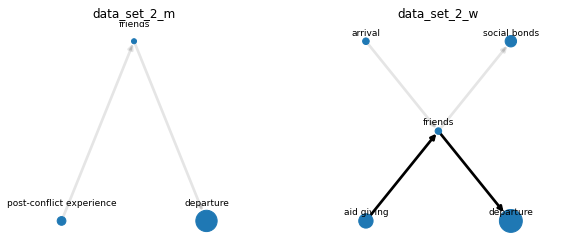

In [111]:
story_start = 'arrival'
story_end = 'departure'
to_analyze = 'friends'

msms_str = ['data_set_2_m', 'data_set_2_w']


fig, axes = plt.subplots(1, 2, figsize=(10, 4))


for ax, name in zip(axes, msms_str):
    graph, tpt, msm, _features_df = get_graphs_msms(name, story_start, story_end)
    print(name)
    print_reactive_pathways_through_node(to_analyze, _features_df, msm, tpt)
    
    subgraph, subgraph_weights = get_subgraph_around_topic(graph, to_analyze)

    spathg_nodes = downsize_nodename_dict(_features_df, msm, subgraph)
    
    plot_small_graph(ax, subgraph, subgraph_weights, msm.pi[spathg_nodes])
    ax.set_title(name)
    print()

### Qualitative description

In narratives of women, the most immediate topic that follows the discussion of friendship is living conditions; this pattern is very weakly present in testimonies of men.


## Observation 7

## Qualitative description

If we look at all possible narrative pathways that can connect arrival to and departure from Birkenau, we  can see that a significant amount of traffic is going through aid giving (4%) and social bonds (3.85%). Their significance can be understood if they are compared to Appel, where 9% of traffic is going through. The amount of traffic going through friendship (0.43%) and food sharing (0.48%) is less significant. I

In case of women, more traffic is going through these nodes, with an exception of food sharing:

- social bonds: 3.9 %
- aid giving: 5 %
- friendship: 0.71
- food sharing:  0.41 %

In case of men, less traffic is going through these nodes:

- social bonds: 3 %
- aid giving: 4 %
- friendship: 0.27
- food sharing:  0.53 %

#### Total traffic going through them in the complete dataset (men and women):

In [49]:
story_start = 'arrival'
story_end = 'departure'
flux = 1
flux_complete = calculate_flux(data_set_1_complete,
                               features_df.KeywordLabel.to_list(),
                               [story_start],[story_end],
                               fraction=flux)
flux_complete_dataset_2 = calculate_flux(data_set_2_complete,
                                         features_df_2.KeywordLabel.to_list(),
                                         [story_start],[story_end],
                                         fraction=flux)


Path flux		%path	%of total	path
arrival-camp intake procedures-living conditions-departure
9.80113805870312
arrival-selections-departure
5.937874748329978
arrival-selections-camp intake procedures-living conditions-transfer-departure
4.912790676629106
arrival-camp intake procedures-tattoo-forced labor-departure
4.5376454945724
arrival-selections-camp intake procedures-mass murder awareness-departure
3.065978583470139
arrival-loved ones' separations-camp intake procedures-kapos-departure
3.020390521576849
arrival-family-departure
2.976804203546988
arrival-camp intake procedures-living conditions-food and thirst-departure
2.757759162282663
arrival-selections-camp intake procedures-living conditions-adaptation methods-departure
2.728145277106787
arrival-camp population-departure
2.486291956305115
arrival-loved ones' separations-camp intake procedures-living conditions-social bonds-departure
2.350362506347031
arrival-camp intake procedures-living conditions-forced labor-aid giving-departur

Path flux		%path	%of total	path
arrival-camp intake procedures-living conditions-departure
9.873183447743424
arrival-selections-departure
5.95753509688955
arrival-selections-camp intake procedures-tattoo-forced labor-departure
4.52820965268115
arrival-camp intake procedures-living conditions-transfer-departure
4.4801171054371185
arrival-selections-camp intake procedures-kapos-departure
3.1469727782290846
arrival-loved ones' separations-camp intake procedures-mass murder awareness-departure
3.1087798820912944
arrival-family-departure
2.85087489514868
arrival-camp intake procedures-living conditions-adaptation methods-departure
2.8489014701375033
arrival-selections-camp intake procedures-living conditions-food and thirst-departure
2.834751133047156
arrival-camp population-departure
2.4031443603683877
arrival-loved ones' separations-camp intake procedures-food and thirst-selections-transfer-departure
2.046689209278558
arrival-camp intake procedures-Appell-departure
1.98814928750393
arriva

Calculate the total traffic going through social bonds

In [29]:
total_social_bonds = []
total_aid_giving = []
total_appell = []
total_friends = []
total_food_sharing = []
total_escapes = []

In [30]:
for i,element in enumerate(flux_complete):
    if 'social bonds' in element.split('-'):
        total_social_bonds.append(flux_complete[element])
print(np.array(total_social_bonds).sum())

3.649909055251304


Calculate the total traffic going through aid giving

In [31]:
for i,element in enumerate(flux_complete):
    if 'aid giving' in element.split('-'):
        total_aid_giving.append(flux_complete[element])
print(np.array(total_aid_giving).sum())

4.09768424793544


Calculate the total traffic going through Appell

In [32]:
for i,element in enumerate(flux_complete):
    if 'Appell' in element.split('-'):
        total_appell.append(flux_complete[element])
print(np.array(total_appell).sum())

9.747604069314539


Calculate the total traffic going through escape

In [33]:
for i,element in enumerate(flux_complete):
    if 'escapes' in element.split('-'):
        total_escapes.append(flux_complete[element])
print(np.array(total_escapes).sum())

0.920663720600445


Calculate the total traffic going through friendship

In [34]:
for i,element in enumerate(flux_complete_dataset_2):
    if 'friends' in element.split('-'):
        total_friends.append(flux_complete_dataset_2[element])
print(np.array(total_friends).sum())

0.6075485016936376


Calculate the total traffic going through food sharing

In [35]:
for i,element in enumerate(flux_complete_dataset_2):
    if 'food sharing' in element.split('-'):
        total_food_sharing.append(flux_complete_dataset_2[element])
print(np.array(total_food_sharing).sum())

0.45637423117767456


#### Total traffic going through them in the dataset of women

In [4]:
story_start = 'arrival'
story_end = 'departure'
flux = 1
flux_w = calculate_flux(data_set_1_w,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
flux_w_dataset_2 = calculate_flux(data_set_2_w,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)


Path flux		%path	%of total	path
arrival-camp intake procedures-living conditions-departure
10.312594940123786
arrival-selections-departure
6.54949332605442
arrival-camp intake procedures-living conditions-transfer-departure
5.362629580853168
arrival-selections-camp intake procedures-tattoo-forced labor-departure
3.7773338375791283
arrival-family-departure
3.1129276056348107
arrival-loved ones' separations-camp intake procedures-mass murder awareness-departure
3.0685444624673854
arrival-selections-camp intake procedures-kapos-departure
3.0435802362915614
arrival-camp intake procedures-living conditions-adaptation methods-departure
2.6796800956073343
arrival-camp population-departure
2.463665860472947
arrival-loved ones' separations-camp intake procedures-living conditions-food and thirst-departure
2.395283575823995
arrival-camp intake procedures-living conditions-social bonds-departure
2.3760060520473765
arrival-selections-transfer-departure
2.1280926060980456
arrival-perpetrators-depar

Path flux		%path	%of total	path
arrival-camp intake procedures-living conditions-departure
10.106842536130774
arrival-selections-departure
6.518401553828868
arrival-camp intake procedures-living conditions-transfer-departure
5.426691916550718
arrival-selections-camp intake procedures-tattoo-forced labor-departure
3.7862520333634855
arrival-family-departure
3.03152654588885
arrival-loved ones' separations-camp intake procedures-mass murder awareness-departure
2.99976617635282
arrival-camp intake procedures-living conditions-adaptation methods-departure
2.99391870725519
arrival-selections-camp intake procedures-kapos-departure
2.951260447884279
arrival-camp population-departure
2.3677288901417373
arrival-loved ones' separations-camp intake procedures-living conditions-food and thirst-departure
2.343763639103079
arrival-camp intake procedures-living conditions-social bonds-departure
1.9270865155255938
arrival-selections-transfer-departure
1.9235313854820584
arrival-perpetrators-departure


In [37]:
total_social_bonds = []
total_aid_giving = []
total_appell = []
total_friends = []
total_food_sharing = []

Calculate the total traffic going through social bonds

In [38]:
for i,element in enumerate(flux_w):
    if 'social bonds' in element.split('-'):
        total_social_bonds.append(flux_w[element])
print(np.array(total_social_bonds).sum())

4.212025717659839


Calculate the total traffic going through aid giving

In [39]:
for i,element in enumerate(flux_w):
    if 'aid giving' in element.split('-'):
        total_aid_giving.append(flux_w[element])
print(np.array(total_aid_giving).sum())

4.928762239297013


Calculate the total traffic going through friendship

In [40]:
for i,element in enumerate(flux_w_dataset_2):
    if 'friends' in element.split('-'):
        total_friends.append(flux_w_dataset_2[element])
print(np.array(total_friends).sum())

0.7491124748765763


Calculate the total traffic going through food sharing

In [41]:
for i,element in enumerate(flux_w_dataset_2):
    if 'food sharing' in element.split('-'):
        total_food_sharing.append(flux_w_dataset_2[element])
        print (element)
        print (flux_w_dataset_2[element])
print(np.array(total_food_sharing).sum())

arrival-aid giving-selections-camp intake procedures-food and thirst-food sharing-departure
0.3874395724383583
arrival-food sharing-camp population-selections-camp intake procedures-mass murder awareness-mass murder-departure
0.031028865123768446
arrival-food sharing-camp population-children-propaganda-departure
0.0010603482003155131
0.4195287857624423


#### Total traffic going through them in the dataset of men

In [42]:
story_start = 'arrival'
story_end = 'departure'
flux = 1
flux_m = calculate_flux(data_set_1_m,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
flux_m_dataset_2 = calculate_flux(data_set_2_m,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)


Path flux		%path	%of total	path
arrival-selections-camp intake procedures-living conditions-departure
8.903392467999193
arrival-camp intake procedures-living conditions-forced labor-departure
6.429958578109304
arrival-selections-departure
4.469107770338612
arrival-camp intake procedures-food and thirst-departure
3.778676384965375
arrival-selections-camp intake procedures-living conditions-kapos-departure
3.3980377083921596
arrival-camp intake procedures-living conditions-transfer-departure
3.3500282268339023
arrival-mass murder awareness-departure
3.2566805957296565
arrival-selections-camp intake procedures-living conditions-adaptation methods-departure
3.1054295742886247
arrival-loved ones' separations-camp intake procedures-tattoo-departure
2.716280802914447
arrival-family-departure
2.5734538016450137
arrival-camp intake procedures-tattoo-forced labor-aid giving-departure
2.535578852284208
arrival-selections-camp intake procedures-tattoo-living conditions-Appell-departure
2.481602909

Path flux		%path	%of total	path
arrival-selections-camp intake procedures-living conditions-departure
8.802778947422514
arrival-camp intake procedures-living conditions-forced labor-departure
6.381697578599401
arrival-selections-departure
4.75065531144633
arrival-camp intake procedures-food and thirst-departure
4.129418801410213
arrival-selections-camp intake procedures-living conditions-kapos-departure
3.419115581264351
arrival-camp intake procedures-living conditions-transfer-departure
3.2685193933707177
arrival-mass murder awareness-departure
3.26579801671822
arrival-selections-camp intake procedures-living conditions-adaptation methods-departure
3.001719768886165
arrival-family-departure
2.6802758650224554
arrival-loved ones' separations-camp intake procedures-tattoo-forced labor-camp population-departure
2.5626983094657
arrival-camp intake procedures-tattoo-departure
2.4134422149866004
arrival-selections-camp intake procedures-tattoo-living conditions-Appell-departure
2.2359704962

In [43]:
total_social_bonds = []
total_aid_giving = []
total_appell = []
total_friends = []
total_food_sharing = []



Calculate the total traffic going through social bonds

In [44]:
for i,element in enumerate(flux_m):
    if 'social bonds' in element.split('-'):
        total_social_bonds.append(flux_m[element])
print(np.array(total_social_bonds).sum())

2.6155282806823905


Calculate the total traffic going through aid giving

In [45]:
for i,element in enumerate(flux_m):
    if 'aid giving' in element.split('-'):
        total_aid_giving.append(flux_m[element])
print(np.array(total_aid_giving).sum())

5.363985476259081


Calculate the total traffic going through friendship

In [46]:
for i,element in enumerate(flux_m_dataset_2):
    if 'friends' in element.split('-'):
        total_friends.append(flux_m_dataset_2[element])
print(np.array(total_friends).sum())

0.37433082977286425


Calculate the total traffic going through food sharing

In [47]:
total_food_sharing = []

In [48]:
for i,element in enumerate(flux_m_dataset_2):
    if 'food sharing' in element.split('-'):
        print (element)
        print (flux_m_dataset_2[element])
        total_food_sharing.append(flux_m_dataset_2[element])
print(np.array(total_food_sharing).sum())

arrival-clothing-living conditions-food sharing-departure
0.4218205590940044
arrival-liberators-post-conflict experience-future message-family-camp intake procedures-tattoo-punishments-selections-loved ones' contacts-food sharing-bombardments-departure
0.09658942808254994
arrival-tattoo-living conditions-mass murder awareness-medical care-food sharing-departure
0.07779149914086719
arrival-food sharing-selections-camp intake procedures-forced labor-adaptation methods-transfer-loved ones' contacts-deceptions-famous Jewish leaders-departure
0.043918109521319505
arrival-personal property seizure-living conditions-kapos-loved ones' contacts-food sharing-departure
0.001764438609827598
arrival-food sharing-selections-camp intake procedures-clothing-food and thirst-physical condition-departure
0.0004856796766072514
0.642369714125176


## Observation 8

### Qualitative Description

In testimonies of women there are important narrative pathways that lead to the discussion of survival explanations and involve social bonds and aid giving as states preceding survival explanations; in testimonies of men such paths have significantly less traffic. We can see a similar pattern with friends and food sharing, though they are less significant.

In [49]:
story_start = 'arrival'
story_end = 'survival explanations'


In [50]:
flux = 1
flux_w = calculate_flux(data_set_1_w,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
print ('\n')
flux_m = calculate_flux(data_set_1_m,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)

Path flux		%path	%of total	path
arrival-camp intake procedures-living conditions-survival explanations
7.235080305153069
arrival-selections-survival explanations
5.5073098124201145
arrival-camp intake procedures-tattoo-forced labor-survival explanations
5.459430721924664
arrival-selections-camp intake procedures-mass murder awareness-survival explanations
3.9605490067187485
arrival-camp intake procedures-living conditions-social bonds-survival explanations
3.9302692133765897
arrival-loved ones' separations-camp intake procedures-Appell-survival explanations
3.748327691859824
arrival-family-survival explanations
3.719584628710844
arrival-selections-camp intake procedures-living conditions-adaptation methods-survival explanations
3.571412103033887
arrival-camp intake procedures-living conditions-selections-Mengele, Josef-survival explanations
3.252000380781941
arrival-selections-camp intake procedures-living conditions-forced labor-aid giving-survival explanations
3.1943947947943037
arri

Path flux		%path	%of total	path
arrival-selections-camp intake procedures-living conditions-survival explanations
6.0732522233022
arrival-selections-survival explanations
5.4973009085957445
arrival-camp intake procedures-living conditions-forced labor-camp population-survival explanations
4.721043330501993
arrival-camp intake procedures-tattoo-forced labor-survival explanations
4.438589998182407
arrival-selections-camp intake procedures-food and thirst-survival explanations
4.344773557875949
arrival-camp intake procedures-living conditions-departure-survival explanations
4.27200721471055
arrival-selections-camp intake procedures-tattoo-survival explanations
4.0230588452034
arrival-loved ones' separations-camp intake procedures-living conditions-food and thirst-selections-loved ones' fates-survival explanations
3.296850376141902
arrival-camp intake procedures-food and thirst-selections-departure-forced marches-survival explanations
3.017742097535407
arrival-selections-camp intake proced

Find social bonds in women narratives

In [51]:
for element in flux_w:
    if 'social bonds' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

arrival-camp intake procedures-living conditions-social bonds-survival explanations
3.9302692133765897


arrival-social bonds-selections-camp intake procedures-living conditions-transfer-transportation-survival explanations
0.6915533617420796


arrival-deportation-camp intake procedures-living conditions-social bonds-rumors-survival explanations
0.5758168103873242


arrival-camp intake procedures-living conditions-social bonds-family-deceptions-survival explanations
0.025414176061156576


arrival-departure-transportation-camp intake procedures-living conditions-social bonds-family-personal property seizure-survival explanations
0.023133948176071277


arrival-post-conflict experience-selections-camp intake procedures-living conditions-social bonds-collaborators-survival explanations
0.006111961387274811


arrival-bystanders-perpetrators-camp intake procedures-living conditions-social bonds-family-personal property seizure-survival explanations
0.0018061701297692407


arrival-social bond

Find aid giving in women narratives

In [52]:
for element in flux_w:
    if 'aid giving' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

arrival-selections-camp intake procedures-living conditions-forced labor-aid giving-survival explanations
3.1943947947943037


arrival-aid giving-selections-camp intake procedures-Appell-suicides-survival explanations
1.0934256229817658


arrival-preferential treatment-aid giving-selections-departure-bystanders-survival explanations
0.19177879473886209




Find social bonds in men narratives

In [53]:
for element in flux_m:
    if 'social bonds' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

arrival-deportation-selections-camp intake procedures-living conditions-social bonds-survival explanations
0.4485308815897854


arrival-social bonds-tattoo-living conditions-Appell-food and thirst-punishments-resistance-survival explanations
0.26764659809097624


arrival-punishments-selections-camp intake procedures-living conditions-social bonds-survival explanations
0.016153567886460194


arrival-suicides-selections-camp intake procedures-living conditions-social bonds-survival explanations
0.0073683241445496196




Find aid giving in men narratives

In [54]:
for element in flux_m:
    if 'aid giving' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

arrival-camp intake procedures-tattoo-forced labor-aid giving-survival explanations
2.366810817121485


arrival-aid giving-selections-departure-German concentration camps-survival explanations
1.1096516862445491


arrival-killings-aid giving-selections-camp intake procedures-clothing-survival explanations
0.8196238958442013


arrival-departure-escapes-adaptation methods-camp intake procedures-living conditions-Appell-forced labor-aid giving-selections-loved ones' separations-survival explanations
0.2787420186272989


arrival-awareness-transfer-aid giving-selections-camp intake procedures-living conditions-camp cultural activities-survival explanations
0.208884925389866


arrival-transfer-aid giving-selections-tattoo-forced labor-physical condition-survival explanations
0.20660758193334636


arrival-self-preservation acts-living conditions-forced labor-aid giving-selections-loved ones' separations-survival explanations
0.03147316841184433


arrival-camp cultural activities-adaptation me

## Visualize

Notice that aid giving and social bonds are "missing" from the plot showing men

17 labels to show
17 labels to show


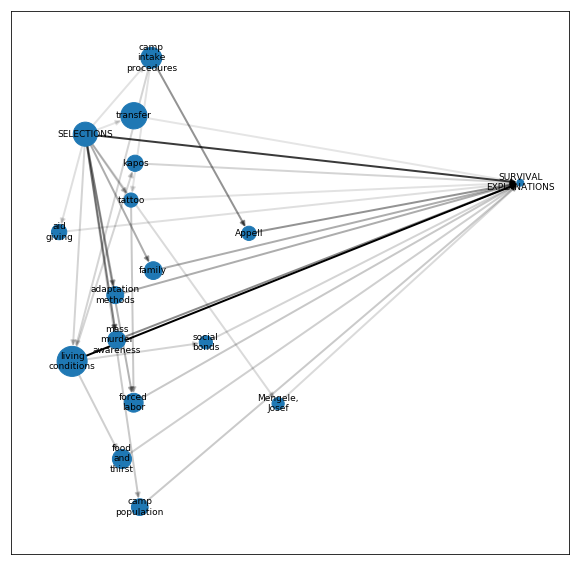

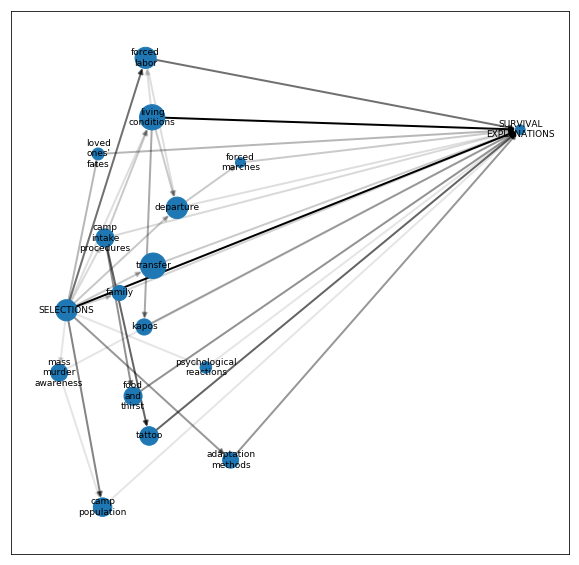

In [68]:
flux = 0.48
visualize_most_important_paths(data_set_1_w,flux,features_df,story_start,story_end,None)
visualize_most_important_paths(data_set_1_m,flux,features_df,story_start,story_end,None)

In [56]:
story_start = 'arrival'
story_end = 'survival explanations'
flux = 1
flux_w = calculate_flux(data_set_2_w,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
print ('\n')
flux_m = calculate_flux(data_set_2_m,features_df_2.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)



Path flux		%path	%of total	path
arrival-camp intake procedures-living conditions-survival explanations
7.104441537230978
arrival-selections-survival explanations
5.722124138144169
arrival-camp intake procedures-tattoo-forced labor-survival explanations
5.132397249821655
arrival-family-survival explanations
3.919879692058937
arrival-selections-camp intake procedures-mass murder awareness-survival explanations
3.7822963342735014
arrival-camp intake procedures-living conditions-adaptation methods-survival explanations
3.7219312240389946
arrival-loved ones' separations-camp intake procedures-Appell-survival explanations
3.6556119498460724
arrival-selections-Mengele, Josef-survival explanations
3.1362395688504248
arrival-camp intake procedures-kapos-survival explanations
2.9809385020899977
arrival-selections-camp intake procedures-living conditions-food and thirst-camp population-survival explanations
2.9308008783530934
arrival-loved ones' separations-camp intake procedures-living condition

Path flux		%path	%of total	path
arrival-selections-camp intake procedures-living conditions-survival explanations
6.302263608081463
arrival-camp intake procedures-living conditions-forced labor-camp population-survival explanations
5.484831428859752
arrival-selections-survival explanations
5.410266362100643
arrival-camp intake procedures-food and thirst-survival explanations
4.541156468104898
arrival-selections-camp intake procedures-tattoo-forced labor-survival explanations
4.128815415393264
arrival-camp intake procedures-living conditions-departure-survival explanations
3.7382816420035114
arrival-selections-camp intake procedures-tattoo-survival explanations
3.6764640021357056
arrival-loved ones' separations-camp intake procedures-living conditions-adaptation methods-survival explanations
3.3576400977392757
arrival-camp intake procedures-living conditions-transfer-killings-survival explanations
3.334537106969704
arrival-selections-departure-transfer-survival explanations
3.2380325840

Find friends in women narratives

In [57]:
for element in flux_w:
    if 'friends' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

arrival-food and thirst-medical care-Mengele, Josef-children-friends-survival explanations
0.8201463549657028


arrival-warnings-camp intake procedures-tattoo-forced labor-perpetrators-aid giving-friends-survival explanations
0.49584983028496465


arrival-friends-social bonds-selections-deceptions-survival explanations
0.30158710061802496


arrival-diseases-medical care-selections-camp intake procedures-clothing-friends-survival explanations
0.09686420956083419


arrival-food additives-selections-camp intake procedures-living conditions-friends-collaborators-survival explanations
0.014913112441344493


arrival-mass murder awareness-adaptation methods-departure-transportation-camp intake procedures-living conditions-friends-survival explanations
0.00639676277618582


arrival-suicides-selections-camp intake procedures-living conditions-friends-survival explanations
0.0020300987855759152


arrival-deceptions-camp intake procedures-living conditions-friends-collaborators-survival explanati

Find food sharing in women narratives

In [58]:
for element in flux_w:
    if 'food sharing' in element.split('-'):
        print (element)
        print (flux_w[element])
        print ('\n')

arrival-deportation-camp intake procedures-living conditions-food and thirst-food sharing-survival explanations
0.5703974026985231


arrival-sexual activities-post-conflict experience-camp intake procedures-forced labor-food sharing-survival explanations
0.033759232665041536


arrival-food sharing-camp population-selections-camp intake procedures-mass murder awareness-adaptation methods-businesses-survival explanations
0.032056131074832114


arrival-rumors-selections-camp intake procedures-tattoo-forced labor-food sharing-survival explanations
0.01820798220772659


arrival-camp procedures-selections-camp intake procedures-tattoo-forced labor-food sharing-survival explanations
3.617560179250131e-06




Find friends in men narratives

In [59]:
for element in flux_m:
    if 'friends' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

arrival-transportation-selections-camp intake procedures-food and thirst-departure-liberators-post-conflict experience-friends-survival explanations
0.3706450654690209


arrival-selections-camp intake procedures-living conditions-social bonds-friends-survival explanations
0.015369524841186526


arrival-friends-adaptation methods-tattoo-living conditions-food and thirst-rumors-survival explanations
0.010218252544183088


arrival-friends-adaptation methods-tattoo-living conditions-Appell-forced labor-transfer-post-conflict activity-survival explanations
0.0016937484080846593




Find food sharing in men narratives

In [60]:
for element in flux_m:
    if 'food sharing' in element.split('-'):
        print (element)
        print (flux_m[element])
        print ('\n')

arrival-food acquisition-selections-camp intake procedures-living conditions-food sharing-survival explanations
0.08540729132286037


arrival-food sharing-selections-camp intake procedures-tattoo-forced labor-barter-survival explanations
0.04208904418717464


arrival-food sharing-selections-camp intake procedures-forced labor-covert activities-survival explanations
0.0017847617669431155




## Observation 9

### Qualitative description

The moment when one particularly needed the help of others was the selection, when the ill and those who were unable to work were selected to be sent to gas chambers. In testimonies we can often read that victims helped each other in these moments (for instance by hiding or holding the ill); yet victims attribute their survival of selections to the help of their peers and friends. This narrative frame corresponds to the following narrative pathways:
- selections-social bonds-survival explanations
- selections-aid giving-survival explanations

These narrative pathways are more significant in testimonies of women than men.


### Visualization

In [61]:
story_start = 'selections'
story_end = 'survival explanations'
flux = 1
flux_w = calculate_flux(data_set_1_w,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)
print ('\n')
flux_m = calculate_flux(data_set_1_m,features_df.KeywordLabel.to_list(),[story_start],[story_end],fraction=flux)

Path flux		%path	%of total	path
selections-camp intake procedures-living conditions-survival explanations
7.225853342645174
selections-survival explanations
5.844149131697455
selections-mass murder awareness-survival explanations
3.9599811734598114
selections-camp intake procedures-Appell-survival explanations
3.7402610489128927
selections-adaptation methods-survival explanations
3.13724899008127
selections-family-survival explanations
3.1242606832767743
selections-forced labor-survival explanations
2.9794008044052087
selections-tattoo-forced labor-survival explanations
2.4856511755572384
selections-camp population-survival explanations
2.4328711622565806
selections-camp intake procedures-living conditions-food and thirst-survival explanations
2.3285583619487893
selections-camp intake procedures-living conditions-kapos-survival explanations
2.194429640083402
selections-living conditions-social bonds-survival explanations
2.1913454059142286
selections-Mengele, Josef-survival explanation

Path flux		%path	%of total	path
selections-camp intake procedures-living conditions-survival explanations
6.059810872023149
selections-survival explanations
6.028528062181431
selections-camp intake procedures-tattoo-survival explanations
4.011066195938619
selections-forced labor-survival explanations
3.7449667342227393
selections-camp population-survival explanations
3.345064358102076
selections-camp intake procedures-food and thirst-survival explanations
3.0633180882388995
selections-adaptation methods-survival explanations
2.9676756225386463
selections-living conditions-kapos-survival explanations
2.5896706371520577
selections-loved ones' fates-survival explanations
2.307094523620373
selections-departure-survival explanations
1.9618021478413916
selections-transfer-survival explanations
1.9210018561687106
selections-camp intake procedures-living conditions-departure-forced marches-survival explanations
1.9176003883935289
selections-family-survival explanations
1.7201425490124551
selec

Find social bonds as transitionary topic between selection and survival explanation in narratives of women

In [62]:
for element in flux_w:
    if 'social bonds' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_w[element])
        print ('\n')

selections-living conditions-social bonds-survival explanations
2.1913454059142286


selections-social bonds-survival explanations
1.211433478275023




Find social bonds as transitionary topic between selection and survival explanation in narratives of men

In [63]:
for element in flux_m:
    if 'social bonds' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_m[element])
        print ('\n')

selections-social bonds-survival explanations
0.471054807722977




Find aid giving as transitionary topic between selection and survival explanation in narratives of women

In [64]:
for element in flux_w:
    if 'aid giving' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_w[element])
        print ('\n')

selections-aid giving-survival explanations
1.9345773525956507


selections-food and thirst-aid giving-survival explanations
0.536303420879465




Find aid giving as transitionary topic between selection and survival explanation in narratives of men

In [65]:
for element in flux_m:
    if 'aid giving' in element.split('-') and len(element.split('-'))<5:
        print (element)
        print (flux_m[element])
        print ('\n')

selections-aid giving-survival explanations
1.2444638520663847




## Interpretation

The main context of solidarity for women was the barack, i.e. the everyday living environment. By contrast, for men solidarity was rather connected with forced labour and the working environment. Therefore, women and men remember about acts of solidarity in different contexts, which also suggests that they took place in different contexts in the past.

We can see a similar pattern with social activity. Women discuss it in the context of the living environment, whereas man discuss it in the context of work environment.

Generally, speaking if we look at the amount of traffic going through social activity and solidarity, we can see that in case of  women more traffic is going towards solidarity and social activity. 

What also illustrates the different role of solidarity and sociability for men and women is that women are likely to attribute their survival to them